# OrganoidMEA Spike Sorting Basics

#Setup information
Need to ad pip install phy


### Downloading the recording

Need to talk about where the recordings come from

Need to generate the probe file for Organoid

In [74]:
import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as sorters
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import matplotlib.pylab as plt
import numpy as np
from pathlib import Path
%matplotlib notebook

### Loading recording and probe information

In [6]:
recordings_folder = Path.cwd().parent / 'recordings'
recording_file = recordings_folder / "OrgMEA_recording_test_02.h5"
print(recording_file)
recording = se.MEArecRecordingExtractor(recording_file, locs_2d=True)

C:\Users\mattm\PycharmProjects\OrganoidMEA\recordings\OrgMEA_recording_test_02.h5


In [7]:
se.SpikeGLXRecordingExtractor?

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The MEArecRecordingExtractor is designed specifically for MEArec datasets.

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [8]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)

Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Sampling frequency: 32000.0
Number of channels: 61


Let's plot the channel locations and a snippet of traces using `spikewidgets`:

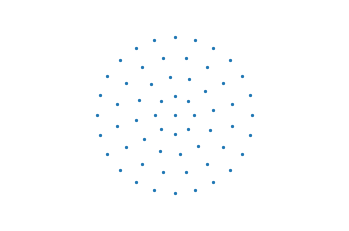

In [9]:
w_elec = sw.plot_electrode_geometry(recording, markersize=5)

The `get_traces()` function returns a NxT numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [10]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [11]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (61, 64000)


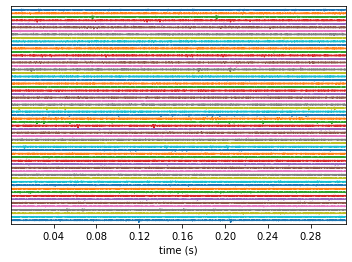

In [14]:
w_ts = sw.plot_timeseries(recording)

Each `spikewidgets` function returns a `Widget` object. You can access the figure and axes with the `figure` and `ax` fields:

In [15]:
w_ts.ax.axis('off')

(0.0, 0.3125, -302.25714111328125, 18437.685607910156)

We can see that the spikes mainly appear separately on different tetrodes. Each tetrode belongs to a different `group`. We can load the `group` information in two ways:

- using the `set_channel_groups` in your RecordingExtractor (manually loading group information)
- loading a probe file using the `load_probe_file` from `spikeextractors` (automatically loading group information)

Let's use the second option. Probe files (`.prb`) also enable users to change the channel map (reorder the channels) and add channel grouping properties and locations. In this case, our probe file will order the channels in reverse and split them in 4 groups, representing the 4 tetrodes.

In [28]:
!cat OrgMEA_252.prb

channel_groups = {
    # Tetrode index
    1:
      {
      'channels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29 , 30, 31, 32, 33, 34, 35, 36, 37, 38, 39 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60],
      },
    #2:
    #  {
    #'channels': [8, 9, 10, 11],
    #  },
    #3:
    #  {
    #  'channels': [4, 5, 6, 7],
    #  },
    #4:
    #  {
    #  'channels': [0, 1, 2, 3],
    #  },
}


In [46]:
recording_prb = se.load_probe_file(recording, 'OrgMEA_252.prb')

In [44]:
print('Original channels:', recording.get_channel_ids())
print('Channels after loading the probe file:', recording_prb.get_channel_ids())
print('Channel groups after loading the probe file:', recording_prb.get_channel_groups())

Original channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Channels after loading the probe file: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Channel groups after loading the probe file: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Preprocessing recordings


Now that the probe information is loaded we can do some preprocessing using `spiketoolkit`.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings, remove a noisy channel, and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

Below, we bandpass filter the recording, remove channel 5, and apply common median reference to the original recording.

In [48]:
recording_f = st.preprocessing.bandpass_filter(recording_prb, freq_min=300, freq_max=6000)
recording_rm_noise = st.preprocessing.remove_bad_channels(recording_f, bad_channel_ids=[5])
recording_cmr = st.preprocessing.common_reference(recording_rm_noise, reference='median')

Now we can extractor traces from the preprocessed recording.

In [49]:
trace_f_snippet = recording_f.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))
trace_cmr_snippet = recording_cmr.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

print(trace_f_snippet.shape)
print(trace_cmr_snippet.shape)

(61, 64000)
(60, 64000)


We can plot the bandpassfiltered snippets below

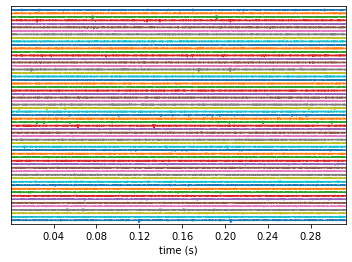

In [52]:
sw.plot_timeseries(recording_f, channel_ids=range(61))

In [54]:
print('Channel ids for CMR recordings:', recording_cmr.get_channel_ids())
print('Channel groups for CMR recording:', recording_cmr.get_channel_groups())

Channel ids for CMR recordings: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
Channel groups for CMR recording: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Spike sorting

We can now run spike sorting on the above recording. We will use `klusta` for this demonstration and we will run spike sorting on each group separately.

Let's first check the installed sorters in spiketoolkit to see if klusta is available. Then we can check the `klusta` default parameters.

We will sort the bandpass filtered recording (the `recording_bpf` object), as there is no external noise and all channels are good :)

In [81]:
sorters.installed_sorter_list

[spikesorters.klusta.klusta.KlustaSorter,
 spikesorters.spyking_circus.spyking_circus.SpykingcircusSorter]

In [56]:
sorters.get_default_params('mountainsort4')

{'detect_sign': -1,
 'adjacency_radius': -1,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': False,
 'whiten': True,
 'curation': False,
 'num_workers': None,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0.15}

In [57]:
sorters.run_sorter?

We will set the `adjacency_radius` to 50 microns as electrodes belonging to the same tetrode are within this distance.

In [58]:
# run spike sorting on entire recording
sorting_KL_all = sorters.run_klusta(recording_f, 
                                    output_folder='results_all_klusta', 
                                    adjacency_radius=50, delete_output_folder=True)
print('Found', len(sorting_KL_all.get_unit_ids()), 'units')

c:\users\mattm\pycharmprojects\organoidmea\venv\lib\site-packages\spikeextractors\extractors\klustaextractors\klustaextractors.py:69: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  F = h5py.File(kwikfile)


Found 42 units


In [59]:
# run spike sorting by group
sorting_KL_split = sorters.run_klusta(recording_f, adjacency_radius=50, 
                                      output_folder='results_split_klusta', 
                                      grouping_property='group')
print('Found', len(sorting_KL_split.get_unit_ids()), 'units')

Found 50 units


The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [63]:
print('Units', sorting_KL_split.get_unit_ids())

Units [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 6, 7, 8, 9]


In [64]:
print('Units', sorting_KL_split.get_unit_spike_train(13))

Units [   626  13600  35422  35925  50810  62594  79769  89226  90935 112436
 116682 165405 179475 216586 235408 262504 288006 297688 300061 319023]


We can use `spikewidgets` functions to quickly visualize some unit features:

<IPython.core.display.Javascript object>


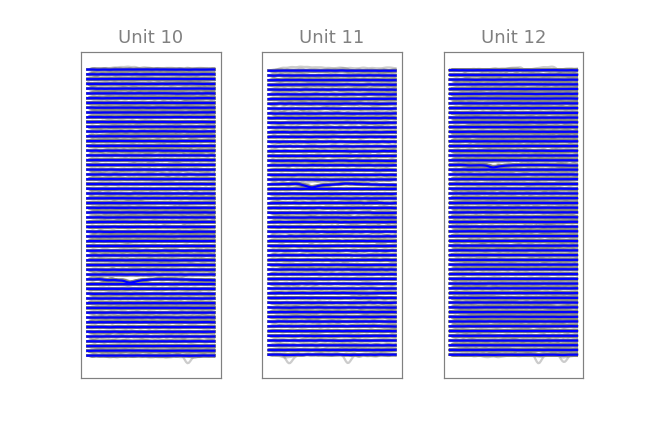

In [76]:
w_wf = sw.plot_unit_waveforms(sorting=sorting_KL_split, recording=recording_f, unit_ids=[10,11,12])

<IPython.core.display.Javascript object>


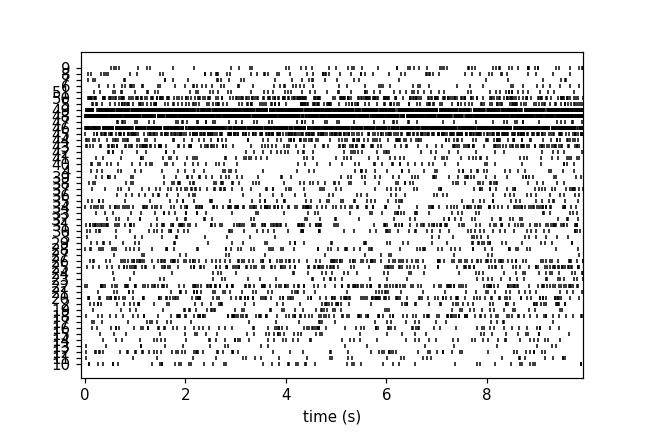

In [75]:
w_rs = sw.plot_rasters(sorting_KL_split)

In [77]:
print('Units', sorting_KL_split.get_unit_ids())

Units [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 6, 7, 8, 9]


We can now perform some automatic curation by thresholding low snr units on the split sorting result

In [78]:
sorting_KL_split_curated = st.curation.threshold_snr(recording=recording, sorting=sorting_KL_split, threshold=5)
print('Curated Units', sorting_KL_split_curated.get_unit_ids())

Curated Units [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 47, 5, 51, 6, 7, 8, 9]


### Manual curation

To perform manual curation we will export the data to Phy. 

In [79]:
st.postprocessing.export_to_phy(recording_f, 
                                sorting_KL_split, output_folder='phy_KL_split', 
                                grouping_property='group')

In [80]:
%%capture --no-display
!phy template-gui phy_KL_split/params.py

After curating the results we can reload it using the `PhySortingExtractor`:

In [33]:
sorting_KL_split_curated = se.PhySortingExtractor('phy_KL_split/')

In [34]:
print(len(sorting_KL_split_curated.get_unit_ids()))

34


### Some more spike sorting!

If you have other sorters installed, you can try to run them:

In [35]:
sorting_MS4 = sorters.run_mountainsort4(recording_f, grouping_property='group',
                                        adjacency_radius=50)

AssertionError: This sorter mountainsort4 is not installed.
        Please install it with:  

       >>> pip install ml_ms4alg

    More information on mountainsort at:
      * https://github.com/flatironinstitute/mountainsort
     

In [ ]:
len(sorting_MS4.get_unit_ids())

In [ ]:
st.postprocessing.export_to_phy(recording_f, sorting_MS4, output_folder='phy_MS4', grouping_property='group')

In [ ]:
%%capture --no-display
!phy template-gui  phy_MS4/params.py

In [ ]:
sorting_MS4_curated = se.PhySortingExtractor('phy_MS4')

### Comparison with ground-truth

MEArec recordings are simulated, therefore we know ground truth information about the spiking times. 
We can load the ground truth `SortingExtractor` as:

In [36]:
sorting_gt = se.MEArecSortingExtractor(recording_file)

Now we can compare the sorting output to the ground truth information:

In [41]:
cmp_KL = sc.compare_sorter_to_ground_truth(sorting_gt, 
                                           sorting_KL_split, 
                                           min_accuracy=0.5)

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [38]:
cmp_KL.get_performance()

NameError: name 'cmp_KL' is not defined

In [ ]:
cmp_KL.get_performance(method='pooled_with_average')

In [ ]:
cmp_MS4 = sc.compare_sorter_to_ground_truth(sorting_gt, 
                                                       sorting_MS4, 
                                                       min_accuracy=0.5)

In [ ]:
cmp_MS4.get_performance()

In [ ]:
cmp_MS4.get_performance(method='pooled_with_average')

## Exercise) Can you improve the performance with manual curation?

### Multi-sorting comparison

Finally, we can compare KL and SC (or more) and automatically curate the sorting output by retaining the matching units between the two (or more) sorters. We will use the `compare_multiple_sorters` function.
The multi sorting comparison builds a graph with all the units from the different sorters, connected with their agreement score. We can use this to extract agreement sorting.

In [43]:
msc = sc.compare_multiple_sorters(sorting_list=[sorting_KL_split, 
                                                sorting_MS4], 
                                  name_list=['KL', 'MS4'],
                                  min_accuracy=0.5, verbose=True)

NameError: name 'sorting_MS4' is not defined

In [ ]:
w_mcp = sw.plot_multicomp_graph(msc)

In [ ]:
sorting_agreement = msc.get_agreement_sorting(minimum_matching=2)

In [ ]:
print('Klusta units', len(sorting_KL_split.get_unit_ids()))
print('Mountainsort units', len(sorting_MS4.get_unit_ids()))
print('Agreement units', len(sorting_agreement.get_unit_ids()))

We can still inspect the agreement sorting using Phy:

In [ ]:
st.postprocessing.export_to_phy(recording_f, 
                                sorting_agreement, 
                                output_folder='phy_AGR', 
                                grouping_property='group')

In [ ]:
%%capture --no-display
!phy template-gui phy_AGR/params.py

### Comparison with ground truth

In [42]:
cmp_agr_gt = sc.compare_sorter_to_ground_truth(sorting_gt, sorting_agreement)

NameError: name 'sorting_agreement' is not defined

In [ ]:
cmp_agr_gt.get_performance()

### Save sorting output

In [ ]:
se.MdaSortingExtractor.write_sorting(sorting_agreement, 'firings_agr.mda')

In [ ]:
se.MdaSortingExtractor.write_sorting(sorting_MS4, 'firings_MS4.mda')